# Data Preparation for Reddit Autos Selfposts<div class="tocSkip">
    
&copy; Jens Albrecht, 2021
    
This notebook can be freely copied and modified.  
Attribution, however, is highly appreciated.

<hr/>

See also: 

Albrecht, Ramachandran, Winkler: **Blueprints for Text Analytics in Python** (O'Reilly 2020)  
Chapter 4: [Preparing Data for Statistics and Machine Learning](https://learning.oreilly.com/library/view/blueprints-for-text/9781492074076/ch04.html#ch-preparation) + [Link to Github](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/README.md)

# Data Preparation<div class='tocSkip'/>

## Setup<div class='tocSkip'/>

Set directory locations. If working on Google Colab: copy files and install required libraries.

In [1]:
import sys, os
ON_COLAB = 'google.colab' in sys.modules

if ON_COLAB:
    GIT_ROOT = 'https://github.com/jsalbr/tdwi-2021-text-mining/raw/main'
    os.system(f'wget {GIT_ROOT}/notebooks/setup.py')

%run -i setup.py

You are working on a local system.
Files will be searched relative to "..".


## Load Python Settings<div class="tocSkip"/>

Common imports, defaults for formatting in Matplotlib, Pandas etc.

In [2]:
%run "$BASE_DIR/notebooks/settings.py"

%reload_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'png'

# to print output of all statements and not just the last
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# otherwise text between $ signs will be interpreted as formula and printed in italic
pd.set_option('display.html.use_mathjax', False)
pd.options.plotting.backend = "matplotlib"

# path to import blueprints packages
sys.path.append('./packages')

# Loading the Data Set

In [3]:
df = pd.read_csv(f"{BASE_DIR}/data/reddit-autos-selfposts-raw.csv", sep=";", decimal=".", parse_dates=['created'])

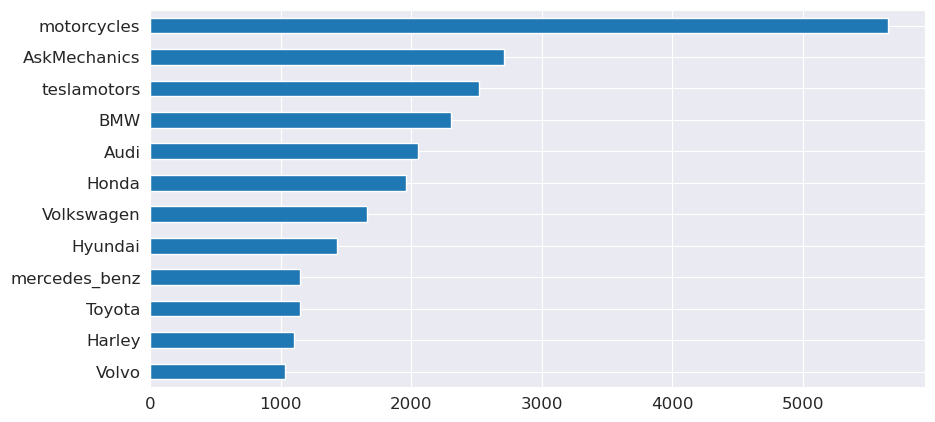

In [4]:
df['subreddit'].value_counts().head(20).plot(kind='barh', height=500).update_yaxes(autorange="reversed")

In [6]:
df.dtypes

subreddit               object
id                      object
created         datetime64[ns]
title                   object
text                    object
num_comments             int64
url                     object
dtype: object

In [7]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
num_comments,24712.00,11.61,33.58,0.00,2.00,5.00,11.00,1320.00


In [8]:
df.describe(include='O').T

,count,unique,top,freq
subreddit,24712,12,motorcycles,5654
id,24712,24712,mw1df9,1
title,24712,24259,"Daily Discussion, Question and Answer, Experiences, and Support Thread",90
text,24712,24440,"If you are new here (or even if you're not), please skim through our [Rules](https://www.reddit.com/r/teslamotors/wiki/rules) to get more familiarity on potential updates or changes and what to ex...",52
url,24712,24712,https://www.reddit.com/r/motorcycles/comments/n0pm72/financing_a_bike_with_bad_credit/,1


# Cleaning Text Data


In [9]:
text = """
After viewing the [PINKIEPOOL Trailer](https://www.youtu.be/watch?v=ieHRoHUg)
it got me thinking about the best match ups.
<lb>Here's my take:<lb><lb>[](/sp)[](/ppseesyou) Deadpool<lb>[](/sp)[](/ajsly)
Captain America<lb>"""

In [10]:
print(text)


After viewing the [PINKIEPOOL Trailer](https://www.youtu.be/watch?v=ieHRoHUg)
it got me thinking about the best match ups.
<lb>Here's my take:<lb><lb>[](/sp)[](/ppseesyou) Deadpool<lb>[](/sp)[](/ajsly)
Captain America<lb>


## Identify Noise with Regular Expressions


In [11]:
import re

RE_SUSPICIOUS = re.compile(r'[&#<>{}\[\]\\]')

def impurity(text, min_len=10):
    """returns the share of suspicious characters in a text"""
    if text == None or len(text) < min_len:
        return 0
    else:
        return len(RE_SUSPICIOUS.findall(text))/len(text)

print(impurity(text))

0.09009009009009009


In [12]:
pd.options.display.max_colwidth = 200
# add new column to data frame
df['impurity'] = df['text'].progress_apply(impurity, min_len=10)

# get the top 3 records
df[['text', 'impurity']].sort_values(by='impurity', ascending=False).head(3)

  0%|          | 0/24712 [00:00<?, ?it/s]

,text,impurity
4529,\[img\]https://i.imgur.com/ac4LgzZ.jpg\[/img\],0.17
6910,[\[url=https://ibb.co/ykmfVL7\]\[img\]](https://ibb.co/ykmfVL7)[https://i.ibb.co/8xnKXFt/20200802-IMG-4829-2.jpg\[/img\]\[/url\]](https://i.ibb.co/8xnKXFt/20200802-IMG-4829-2.jpg[/img][/url]),0.13
905,&amp;#x200B;\n\n![video](3v4jrqcbtn961),0.11


## Noise Removal with Regular Expressions


In [ ]:
import html

def clean(text):
    # convert html escapes like &amp; to characters.
    text = html.unescape(text) 
    text = html.unescape(text) 
    # tags like <tab>
    text = re.sub(r'<[^<>]*>', ' ', text)
    # markdown URLs like [Some text](https://....)
    text = re.sub(r'\[([^\[\]]*)\]\([^\(\)]*\)', r'\1', text)
    # text or code in brackets like [0]
    text = re.sub(r'\[[^\[\]]*\]', ' ', text)
    # standalone sequences of specials, matches &# but not #cool
    text = re.sub(r'(?:^|\s)[&#<>{}\[\]+|\\:-]{1,}(?:\s|$)', ' ', text)
    # standalone sequences of hyphens like --- or ==
    text = re.sub(r'(?:^|\s)[\-=\+]{2,}(?:\s|$)', ' ', text)
    # sequences of white spaces
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

In [ ]:
clean_text = clean(text)
print(clean_text)
print("Impurity:", impurity(clean_text))

In [ ]:
df['clean_text'] = df['text'].progress_map(clean)
df['impurity']   = df['clean_text'].apply(impurity, min_len=20)

df[['clean_text', 'impurity']].sort_values(by='impurity', ascending=False).head(3)

## Character Normalization with textacy


In [ ]:
text = "The café “Saint-Raphaël” is loca-\nted on Côte dʼAzur."

In [ ]:
import textacy
import textacy.preprocessing as tprep

def normalize(text):
    text = tprep.normalize.hyphenated_words(text)
    text = tprep.normalize.quotation_marks(text)
    text = tprep.normalize.unicode(text)
    text = tprep.remove.accents(text)
    return text

print(normalize(text))

In [ ]:
df['clean_text'] = df['clean_text'].progress_map(normalize)

## Pattern-based Data Masking with textacy


In [ ]:
from textacy.preprocessing.resources import RE_URL
from blueprints.exploration import count_words

count_words(df, column='clean_text', preprocess=RE_URL.findall).head(3)

In [ ]:
from textacy.preprocessing.replace import urls as replace_urls

text = "Check out https://spacy.io/usage/spacy-101"

# using default substitution _URL_
print(replace_urls(text))

In [ ]:
df['clean_text'] = df['clean_text'].progress_map(replace_urls)

## Checkpoint: Save the Cleaned Data

In [ ]:
df['text'] = df['title'] + ': ' + df['clean_text']

df[['subreddit', 'text']].sample(5)

In [ ]:
df.drop(columns=['clean_text', 'impurity'], inplace=True)

In [ ]:
df.to_csv("reddit-autos-selfposts-cleaned.csv", sep=";", decimal=".", index=False)

# Linguistic Processing with spaCy


## Instantiating a Pipeline


In [ ]:
import spacy
nlp = spacy.load('en_core_web_sm')

In [ ]:
nlp.pipeline

## Processing Text


In [ ]:
text = "The BMW X5 and the Mercedes GLK are interesting cars. Does VW have models like these?"
doc = nlp(text)

In [ ]:
for token in doc:
    print(token, end="|")

In [ ]:
from blueprints.preparation import display_nlp

display_nlp(doc)

## Extracting Lemmas based on Part-of-Speech


In [ ]:
nouns = [t for t in doc if t.pos_ in ['NOUN', 'PROPN']]
print(nouns)

In [ ]:
def extract_lemmas(doc, include_pos=None, exclude_pos=[]):
    return [t.lemma_ 
            for t in doc 
            if (include_pos==None or t.pos_ in include_pos) and t.pos_ not in exclude_pos]

lemmas = extract_lemmas(doc, include_pos=['NOUN', 'PROPN'])
print(lemmas)

## Extracting Named Entities

### Model-based Named Entity Recognition (NER)


In [ ]:
doc = nlp(text)

for ent in doc.ents:
    print(f"({ent.text}, {ent.label_})", end=" ")

In [ ]:
from spacy import displacy

displacy.render(doc, style='ent', jupyter=True)

In [ ]:
def extract_entities(doc, include_types=None):

    return [t.text for t in doc if t.ent_type_ in include_types]

print(extract_entities(doc, ['ORG', 'PERSON']))

### Rule-based NER

In [ ]:
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("merge_entities")

doc = nlp(text)
displacy.render(doc, style='ent', jupyter=True)

In [ ]:
import cars

cars.brands[:5]
cars.models[:5]

Choose a relaxed pattern - favors high recall but will result in false positives

In [ ]:
patterns = [{"label": "BRAND", 
             "pattern": [{"LOWER": {"IN": cars.brands}, 
                          "POS": {"IN": ["PROPN", "NOUN", "ADJ"] }
                         }]},
            {"label": "MODEL", 
             "pattern": [{"LOWER": {"IN": cars.models}, 
                          "POS": {"IN": ["PROPN", "NOUN", "ADJ"] }
                         }]}]

In [ ]:
nlp = spacy.load("en_core_web_sm")
nlp.add_pipe("merge_entities")

In [ ]:
ruler = nlp.add_pipe("entity_ruler", config={"overwrite_ents": True})
ruler.add_patterns(patterns)

In [ ]:
text = "The BMW X5 and the Mercedes GLK are interesting cars. Does VW have models like these?"

doc = nlp(text)
displacy.render(doc, style='ent', jupyter=True)
# display_nlp(doc)

In [ ]:
'spark' in cars.models

In [ ]:
text = "The spark plugs in my Z4 are making trouble."

doc = nlp(text)
displacy.render(doc, style='ent', jupyter=True)
# display_nlp(doc)

In [ ]:
text = "I currently have a 2018 honda civic that I'd be getting rid of"

doc = nlp(text)
displacy.render(doc, style='ent', jupyter=True)
# display_nlp(doc)

In [ ]:
text = "I hate Mercedes A-Class"

doc = nlp(text)
displacy.render(doc, style='ent', jupyter=True)
# display_nlp(doc)

In [ ]:
text = "I hate A Mercedes"

doc = nlp(text)
displacy.render(doc, style='ent', jupyter=True)
display_nlp(doc)

In [ ]:
text = "Is a 2017 Tesla Model S worth it in 2021?"

doc = nlp(text)
displacy.render(doc, style='ent', jupyter=True)
display_nlp(doc)

## Blueprint: One Function to Get It All


In [ ]:
def extract_nlp(doc):
    return {
    'lemmas' : extract_lemmas(doc, include_pos = ['NOUN', 'PROPN', 'VERB', 'ADJ', 'NUM']),
    'nouns'  : extract_lemmas(doc, include_pos = ['NOUN', 'PROPN']),
    'brands' : extract_entities(doc, ['BRAND']),
    'models' : extract_entities(doc, ['MODEL'])
    }

In [ ]:
nlp = spacy.load('en_core_web_sm', disable=[])

_ = nlp.add_pipe("merge_entities")
ruler = nlp.add_pipe("entity_ruler", config={"overwrite_ents": True})
ruler.add_patterns(patterns)

[pipe[0] for pipe in nlp.pipeline]

In [ ]:
text = "The BMW X5 and the Mercedes GLK are interesting cars. Does VW have models like these?"

doc = nlp(text)
for col, values in extract_nlp(doc).items():
    print(f"{col}: {values}")

In [ ]:
nlp_columns = list(extract_nlp(nlp.make_doc('')).keys())
print(nlp_columns)

## Blueprint: Using spaCy on a Large Data Set


In [ ]:
df = pd.read_csv(f"{BASE_DIR}/data/reddit-autos-selfposts-cleaned.csv", sep=";", decimal=".")

In [ ]:
len(df)

In [ ]:
pd.options.display.max_colwidth = 1000
df[['subreddit', 'text']].sample(3)

In [ ]:
for col in nlp_columns:
    df[col] = None

**On Colab**: Choose "Runtime"&rarr;"Change Runtime Type"&rarr;"GPU" to benefit from the GPUs.

In [ ]:
if spacy.prefer_gpu():
    print("Working on GPU.")
else:
    print("No GPU found, working on CPU.")

In [ ]:
nlp = spacy.load('en_core_web_sm', disable=[])

_ = nlp.add_pipe("merge_entities")
ruler = nlp.add_pipe("entity_ruler", config={"overwrite_ents": True})
ruler.add_patterns(patterns)

In [ ]:
# full data set takes about 5 minutes
# for faster processing use a sample like this
# df = df.sample(500)

In [ ]:
batch_size = 50
batches = math.ceil(len(df) / batch_size) ###

for i in tqdm(range(0, len(df), batch_size), total=batches):
    docs = nlp.pipe(df['text'][i:i+batch_size])
    
    for j, doc in enumerate(docs):
        for col, values in extract_nlp(doc).items():
            df[col].iloc[i+j] = values

In [ ]:
df[['text', 'lemmas', 'brands', 'models']].sample(10)

# Finalizing and Saving the Result

## Some Quick Frequency Analyses

In [ ]:
freq_df = count_words(df, 'nouns')

freq_df.head(20).plot(kind='barh', height=500).update_yaxes(autorange="reversed")

In [ ]:
from blueprints.exploration import wordcloud

wordcloud(freq_df['freq'], max_words=100)

In [ ]:
freq_df = count_words(df, 'models')
wordcloud(freq_df['freq'])

In [ ]:
freq_df = count_words(df, 'brands')
wordcloud(freq_df['freq'])

In [ ]:
freq_df.index

## Synonym Resolution

In [ ]:
synonyms = { brand: brand for brand in cars.brands }
synonyms['mercedes-menz'] = 'mercedes'
synonyms['volkswagen'] = 'vw'

df['brands'] = df['brands'].progress_map(lambda brands: [synonyms[b.lower()] for b in brands])

In [ ]:
freq_df = count_words(df, 'brands')
wordcloud(freq_df['freq'])

## Saving the Prepared Data

Alternatively into a SQL database or JSON file.

In [ ]:
# convert lists of tokens into space-separated strings for csv-saving
df[nlp_columns] = df[nlp_columns].applymap(lambda items: ' '.join(items).lower())

df.to_csv(f"reddit-autos-selfposts-prepared.csv", sep=";", decimal=".", index=False)

In [ ]:
# restore lists
# df[nlp_columns] = df[nlp_columns].applymap(lambda items: items.split())